In [39]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import numpy as np
from PIL import Image
from skimage import img_as_ubyte
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
# 设置随机种子
torch.manual_seed(0)
np.random.seed(0)

# 检查是否有可用的GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def block_no_expand(PIL_img):
    image = np.array(PIL_img)
    # Scale the image intensity
    image = np.interp(image, (0, 255), (0, 255/4))
    # Convert the image to binary
    image_ht = Image.fromarray(image).convert("1")
    # Convert the binary image to 8-bit unsigned integer format
    image_ht = img_as_ubyte(image_ht)
    return image_ht

def Inv_HT(img_ht, radius=3, sigma_s=20, cnts=1):
    halftone = img_ht.copy()
    I = cv2.GaussianBlur(halftone, (radius, radius), 0)
    for i in range(cnts):
        I = cv2.bilateralFilter(I, radius, sigma_s, sigma_s)
    ehist = cv2.equalizeHist(I)
    return ehist

# 定义一个转换，将图像转换为白底黑字，并转换为PyTorch张量，然后应用block_no_expand函数
transform_with_block_no_expand_and_IHT = transforms.Compose([
    transforms.Lambda(lambda x: Image.fromarray(255 - np.array(x))),  # 将图像转换为白底黑字
    transforms.Lambda(lambda x: block_no_expand(x)),  # 应用block_no_expand函数
    transforms.Lambda(lambda x: Inv_HT(x)),  # 应用IHT函数
    transforms.ToTensor(),  # 转换为PyTorch张量
])


transform = transforms.Compose([
    transforms.Lambda(lambda x: Image.fromarray(255 - np.array(x))),  # 将图像转换为白底黑字
    transforms.ToTensor(),
])

# 定义网络模型
num_classes = 10  # 图片的类别数(图片中的数字是0-9)

class Net(nn.Module):
    """ mnist手写数字识别-神经网络"""

    def __init__(self):
        super().__init__()
        # 特征提取网络
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 第一层卷积,卷积核大小为3*3
        self.pool1 = nn.MaxPool2d(2)  # 设置池化层，池化核大小为2*2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # 第二层卷积,卷积核大小为3*3
        self.pool2 = nn.MaxPool2d(2)

        # 分类网络
        self.fc1 = nn.Linear(1600, 64)
        self.fc2 = nn.Linear(64, num_classes)

    # 前向传播
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 加载数据集
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform_with_block_no_expand_and_IHT)
valid_dataset1 = datasets.MNIST('./data', train=False, transform=transform_with_block_no_expand_and_IHT)
valid_dataset2 = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8196, shuffle=True)
valid_loader1 = torch.utils.data.DataLoader(valid_dataset1, batch_size=8196, shuffle=False)
valid_loader2 = torch.utils.data.DataLoader(valid_dataset2, batch_size=8196, shuffle=False)

# 初始化模型和优化器
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

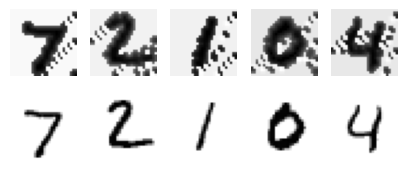

In [40]:
def show_images(loader1, loader2):
    plt.figure(figsize=(5, 2))  # 创建一个新的图形

    # 显示来自loader1的图像
    dataiter = iter(loader1)
    images, labels = next(dataiter)
    images = images[:5]
    for i in range(5):
        plt.subplot(2, 5, i+1)  # 在新的图形上添加子图
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')  # 关闭坐标轴

    # 显示来自loader2的图像
    dataiter = iter(loader2)
    images, labels = next(dataiter)
    images = images[:5]
    for i in range(5):
        plt.subplot(2, 5, i+6)  # 在新的图形上添加子图
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')  # 关闭坐标轴

    plt.savefig('images.png', dpi=300, bbox_inches='tight')  # 保存图像
    plt.show()

show_images(valid_loader1, valid_loader2)

In [41]:
# 训练模型
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # 计算训练损失
        running_loss += loss.item() * inputs.size(0)
        # 计算训练准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 计算平均训练损失和训练准确率
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    print(f'Epoch {epoch+1}/{10}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')


Epoch 1/10:
Train Loss: 2.2382, Train Acc: 0.3005
Epoch 2/10:
Train Loss: 1.8535, Train Acc: 0.6081
Epoch 3/10:
Train Loss: 1.1850, Train Acc: 0.7321
Epoch 4/10:
Train Loss: 0.7278, Train Acc: 0.7854
Epoch 5/10:
Train Loss: 0.5532, Train Acc: 0.8236
Epoch 6/10:
Train Loss: 0.4689, Train Acc: 0.8553
Epoch 7/10:
Train Loss: 0.4157, Train Acc: 0.8720
Epoch 8/10:
Train Loss: 0.3797, Train Acc: 0.8840
Epoch 9/10:
Train Loss: 0.3476, Train Acc: 0.8942
Epoch 10/10:
Train Loss: 0.3195, Train Acc: 0.9020
Accuracy of the network on the test images: 0 %
Accuracy of the network on the test images: 0 %


In [42]:
# 测试模型
def test_model(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (100*correct / total))

test_model(valid_loader1)
test_model(valid_loader2)

Accuracy of the network on the test images: 91 %
Accuracy of the network on the test images: 68 %
